<a href="https://colab.research.google.com/github/Deanazor/hard_helmet/blob/master/detr_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive, output
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!rm -rf vortex
!git clone https://github.com/nodefluxio/vortex.git
!cd vortex && pip install --ignore-installed --timeout=10000 ./src/development
!cd vortex && pip install --ignore-installed --timeout=10000 ./src/runtime[onnxruntime]
# see https://github.com/PyTorchLightning/pytorch-lightning/issues/4533
!pip install torchtext==0.7
output.clear()

In [7]:
!pip install --force-reinstall tqdm==4.49

     |████████████████████████████████| 69 kB 3.0 MB/s 
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.62.3
    Uninstalling tqdm-4.62.3:
      Successfully uninstalled tqdm-4.62.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
moviepy 0.2.3.5 requires decorator<5.0,>=4.0.2, but you have decorator 5.1.0 which is incompatible.


<h2>Restart notebook after finish install</h2>

In [2]:
from google.colab import output

In [3]:
!gdown --id 1kBZCghfd7YCR0YvJEcb84DbpoTcVNmpq
!gdown --id 1H81OPUoec_Eae67VaAFOguwbW3poovR-
!gdown --id 1HR7uNYUrG932aoBjS1uq27I5xfMaW31x
!gdown --id 15Az6cIdA1RotN3TkaN9GhZD9nH-bClnZ
output.clear()

In [4]:
!mkdir module
!mv /content/dataset.py /content/module
!mv /content/model.py /content/module
!mv /content/utils.py /content/module

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision as vision
import os

import pytorch_lightning as pl

from collections import OrderedDict

from vortex.development.utils.registry import Registry
from vortex.development.networks.models import ModelBase
from vortex.development.utils.profiler.lightning import Profiler
from abc import abstractmethod

from vortex.development.exporter.onnx import ONNXExporter
from vortex.development.utils.runtime_wrapper import RuntimeWrapper

from easydict import EasyDict
from copy import copy
from pathlib import Path

In [6]:
from module.model import build_model
from module.dataset import build_dataset, BetterCOCO, COCODetection, VOCDetection, CocoEvaluator
from module.utils import collate_fn

# Vortex Classes

## Data Class

In [7]:
class DataLoader(pl.LightningDataModule):
    def __init__(self, args: dict):
        super().__init__()
        # assume args has the following structure
        # module: '...', args: {...}
        self.args = args['dataset']
        self.loader_args = args['dataloader']
        self.prepare_data()
    
    def _init_train_set(self):
        # support VOC and COCO dataset
        args = self.args
        args['args'].update({'image_set': 'train'})
        self.train_dataset = build_dataset(**args)
        # VOC has 20 class and COCO actually has 80 class,
        # but from DETR model, it is defined as 91 class with some class defined as N/A.
        if isinstance(self.train_dataset,VOCDetection):
            self.num_classes = 3
        elif isinstance(self.train_dataset,COCODetection):
            self.num_classes = 3
    
    def _init_val_set(self):
        args = self.args
        # validate on train for now
        args['args'].update({'image_set': 'train'})
        self.val_dataset = build_dataset(**args)
        if isinstance(self.val_dataset, VOCDetection):
            # we customize VOC dataset to be able to use COCO validator
            # here we convert our dataset to COCO format for validation and
            # load as coco dataset. Note that BetterCOCO dataset is derived from COCO
            # with additional method to easily visualize image and label using mapping style
            filename = Path('tmp/coco_fmt.json')
            filename.parent.mkdir(exist_ok=True,parents=True)
            self.val_dataset.to_coco(filename=filename)
            self.val_coco_fmt = BetterCOCO(filename)
        else: # assume COCO
            filename = args['args']['ann_file']
            root = args['args']['img_folder']
            self.val_coco_fmt = BetterCOCO(filename,root=root)

    def prepare_data(self):
        if not hasattr(self, 'train_dataset'):
            self._init_train_set()
        if not hasattr(self, 'val_dataset'):
            self._init_val_set()
    
    def train_dataloader(self):
        kwargs = self.loader_args
        kwargs.update({'collate_fn': collate_fn})
        return torch.utils.data.DataLoader(self.train_dataset, **kwargs)
    
    def val_dataloader(self):
        kwargs = copy(self.loader_args)
        kwargs.update(dict(
            collate_fn=collate_fn,
            shuffle=False
        ))
        return torch.utils.data.DataLoader(self.val_dataset, **kwargs)

import os, sys

# Helper contex manager to suppress python print to std out.
# This will be used to disable COCO evaluator print.
class SuppressedPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

## Model Class

In [8]:
class DETR(ModelBase):
    def __init__(self, args: dict, gt=None):
        super().__init__()
        args.setdefault('device', self.device)
        args.setdefault('num_classes', 3)
        args = EasyDict(args)
        self.args = args
        model, criterion, postprocessors = build_model(args)
        self.model = model
        self.criterion = criterion
        self.postprocessors = postprocessors
        self.init_evaluator(gt)
    
    def init_evaluator(self, gt=None):
        # gt can be COCO object from pycocotools or None (can be specified later)
        # here we use CocoEvaluator from pycocotools to validate the model.
        # This method may need to be recalled again after validation to reset the state
        # of the validator
        self.gt = gt
        self.coco_evaluator = CocoEvaluator(self.gt, ['bbox']) \
            if self.gt else None

    def available_metrics(self):
        # skip for now
        return None

    def output_format(self):
        # skip for now
        return {}

    def predict(self, *args, **kwargs):
        # simply do forward for now
        return self.model(*args,**kwargs)
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss_dict = self.criterion(y_hat, y)
        # weight for each loss
        weight_dict = self.criterion.weight_dict
        # total loss
        loss = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
        # log totall loss
        self.log('train_loss', loss.detach(), on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, targets = batch
        outputs = self(x)
        # output is dictionary with 'pred_logits', 'pred_boxes', 'aux_outputs' fields
        # with:
        # - pred_logits' shape: NxDx(C+1) where C is number of classes
        # - pred_boxes' shape: NxDx4
        loss_dict = self.criterion(outputs, targets)
        weight_dict = self.criterion.weight_dict
        loss = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
        self.log('val_loss', loss.detach(), logger=True)
        if self.coco_evaluator is None:
            return
        orig_target_sizes = torch.stack([t["orig_size"] for t in targets], dim=0)
        results = self.postprocessors['bbox'](outputs, orig_target_sizes)
        # can't be empty for now, skip if empty
        if len(results) == 0:
            return
        res = {int(target['image_id']): output for target, output in zip(targets, results)}
        self.coco_evaluator.update(res)
    
    def validation_epoch_end(self, validation_step_outputs):
        coco_evaluator = self.coco_evaluator
        if coco_evaluator is not None:
            # cant compute on empty results
            if len(coco_evaluator.eval_imgs['bbox']):
                with SuppressedPrints():
                    coco_evaluator.synchronize_between_processes()
                    coco_evaluator.accumulate()
                    coco_evaluator.summarize()
                res = coco_evaluator.coco_eval['bbox'].stats.tolist()
                params = coco_evaluator.coco_eval['bbox'].params
                iou_low, iou_high = params.iouThrs[0], params.iouThrs[-1]
                max_det_l, max_det_m, max_det_h = params.maxDets
                legends = [
                    f'(AP) @[ IoU={iou_low}:{iou_high} | area=   all | maxDets={max_det_h} ]',
                    f'(AP) @[ IoU=0.50      | area=   all | maxDets={max_det_h} ]',
                    f'(AP) @[ IoU=0.75      | area=   all | maxDets={max_det_h} ]',
                    f'(AP) @[ IoU={iou_low}:{iou_high} | area= small | maxDets={max_det_h} ]',
                    f'(AP) @[ IoU={iou_low}:{iou_high} | area=medium | maxDets={max_det_h} ]',
                    f'(AP) @[ IoU={iou_low}:{iou_high} | area= large | maxDets={max_det_h} ]',
                    f'(AR) @[ IoU={iou_low}:{iou_high} | area=   all | maxDets={max_det_l} ]',
                    f'(AR) @[ IoU={iou_low}:{iou_high} | area=   all | maxDets={max_det_m} ]',
                    f'(AR) @[ IoU={iou_low}:{iou_high} | area= small | maxDets={max_det_h} ]',
                    f'(AR) @[ IoU={iou_low}:{iou_high} | area=medium | maxDets={max_det_h} ]',
                    f'(AR) @[ IoU={iou_low}:{iou_high} | area= large | maxDets={max_det_h} ]',
                ]
                self.log_dict(dict(zip(legends,res)), on_epoch=True, prog_bar=False, logger=True)
                mAP, mAP50, mAP75 = res[:3]
            # for empty results, just report zero for now
            else:
                mAP, mAP50, mAP75 = 0, 0, 0
            self.log('mean AP', mAP, on_epoch=True, logger=True, prog_bar=True)
            self.log('mean AP (50)', mAP50, on_epoch=True, logger=True, prog_bar=True)
            self.log('mean AP (75)', mAP75, on_epoch=True, logger=True, prog_bar=True)
        self.init_evaluator(self.gt) # restart evaluator for next epoch
    
    def configure_optimizers(self):
        args = self.args
        model_without_ddp = self.model
        param_dicts = [
            {"params": [p for n, p in model_without_ddp.named_parameters() if "backbone" not in n and p.requires_grad]},
            {
                "params": [p for n, p in model_without_ddp.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": args.lr_backbone,
            },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=args.lr,
                                    weight_decay=args.weight_decay)
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, args.lr_drop)
        return dict(
            optimizer=optimizer,
            lr_scheduler=lr_scheduler,
        )

In [9]:
CLASSES = [
            'head',
           'helmet',
           'person'
]

def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def detect(im, model, transform):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.7

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    return probas[keep], bboxes_scaled

In [10]:
class DETRPreprocess(nn.Module):
    __constants__ = ['mean','std','scale']
    def __init__(self):
        super().__init__()
        #  value for RGB
        mean = torch.tensor([0.485, 0.456, 0.406]).reshape(-1,1,1)
        std  = torch.tensor([0.229, 0.224, 0.225]).reshape(-1,1,1)
        # scale to 0...1
        scale = torch.tensor([255.],dtype=torch.float32)
        self.register_buffer('mean', mean)
        self.register_buffer('std', std)
        self.register_buffer('scale', scale)
    
    def forward(self, x):
        # assume NHWC layout,
        # reverse order from BGR to RGB
        # since the weight is trained in RGB format
        x = torch.flip(x,[-1])
        # transpose from NHWC to NCHW
        x = x.permute(0,3,1,2)
        # finally normalize the value
        # and we're done
        x = x.div(self.scale)
        x = x.sub_(self.mean).div_(self.std)
        return x

In [11]:
class DETRPostProcess(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, outputs, score_threshold):
        # from the model above, we know that the output is dictionary of tensor
        out_logits, out_bbox = outputs['pred_logits'], outputs['pred_boxes']

        # peform softmax and extract confidence score and labels
        prob = torch.nn.functional.softmax(out_logits, -1)
        scores, labels = prob[..., :-1].max(-1)

        # selection based on threshold
        # assume single batch
        keep = scores > score_threshold
        keep = keep.nonzero()[...,-1]
        out_bbox = torch.index_select(out_bbox,index=keep,dim=1)
        # unsqueeze to match dimension of out_bbox
        scores = torch.index_select(scores,index=keep,dim=1).unsqueeze(-1)
        labels = torch.index_select(labels,index=keep,dim=1).float().unsqueeze(-1)

        # convert to xyxy and then join them together
        # also note the order of the output tensor, no specific order is necessary
        # but we'll tell vortex about our format later.
        # For clarity, this format is [x1,y1,x2,y2,score,label] for each detected instance.
        # Also note that we have 3-dimensional output NxDx6,
        # where N is number of batch (1 in this case), D is the number of detected object,
        # and 6 is the detection value (bounding box, scores and label).
        bboxes = box_cxcywh_to_xyxy(out_bbox.squeeze(0)).unsqueeze(0)
        return torch.cat((bboxes,scores,labels),-1)

In [14]:
class DETRInference(nn.Module):
    def __init__(self,args, torch_path=None):
        super().__init__()
        self.detr = DETR(args)
        self.preprocess  = DETRPreprocess()
        self.postprocess = DETRPostProcess()
        if torch_path is not None:
            self.detr.load_state_dict(torch.load(torch_path, map_location=torch.device('cpu')))

    def forward(self, x, score_threshold):
        x = self.preprocess(x)
        output = self.detr(x)
        x = {'pred_logits':output['pred_logits'],
             'pred_boxes' : output['pred_boxes']}
        x = self.postprocess(x,score_threshold)
        return x

## Helper Functions

In [ ]:
# Helper function to create pytorch lighnting's trainer.
# Accepts dictionary containing trainer configuration and return Trainer instance.
def build_trainer(args: dict):
    args = EasyDict(args['trainer'])
    loggers = [
        pl.loggers.TensorBoardLogger('logs/'),
    ]
    trainer = pl.Trainer(
        max_epochs=args.max_epochs, gpus=args.gpus, logger=loggers,
        check_val_every_n_epoch=args.check_val_every_n_epoch
    )
    return trainer

def load_state_dict(backbone):
    if backbone=='resnet50':
        state_dict = torch.hub.load_state_dict_from_url(
            url='https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth',
            map_location='cpu', check_hash=True)
        return state_dict

def train(args: dict, model, dataset, onnx_path=None, torch_path=None):
    # let's start from pretrained to save time
    # here we will start from fully pretrained model if we are training on COCO,
    # for VOC, we'll take the pretrained coco but class embedding layers.
    state_dict = load_state_dict(args['backbone'])

    if torch_path is not None and os.path.isfile(torch_path):
        model.load_state_dict(torch.load(torch_path))
    elif state_dict is not None:
        if dataset.num_classes==91:
            # we have coco here, can safely load all from state dict
            model.model.load_state_dict(state_dict['model'],strict=True)
        else:
            # reject trained class embedding, return to random
            filtered = list(filter(lambda x: 'class_embed' not in x, state_dict['model'].keys()))
            state_dict = {key: state_dict['model'][key] for key in filtered}
            model.model.load_state_dict(state_dict,strict=False)
    trainer = build_trainer(args)
    # pass gt from dataset to model's evaluator
    val_gt = dataset.val_coco_fmt
    model.init_evaluator(val_gt)
    # do some training
    trainer.fit(model, dataset)

    if onnx_path is not None:
        exporter = ONNXExporter(dataset=dataset)
        exporter(model, onnx_path)
    if torch_path is not None:
        torch.save(model.state_dict(), torch_path)

# Training

## Load config file

In [18]:
import argparse
import yaml
if hasattr(__builtins__,'__IPYTHON__'):
    # running on notebook, for demonstration purpose
    config_file = 'config.yml'
else:
    parser = argparse.ArgumentParser()
    parser.add_argument('--config',default='config.yml')
    args = parser.parse_args()
    config_file = args.config
with open(config_file) as f:
    args = yaml.load(f)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: YAMLLoadWarning:

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.



## Create model and dataset object

In [ ]:
dataset = DataLoader(args)
args.update({'num_classes': dataset.num_classes})
model = DETR(args)

loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!


## save paths

In [ ]:
path = "/content/drive/MyDrive/project_3/"
onnx_path = path + 'saved_models/helmet_model.onnx'
torch_path = path + 'saved_models/helmet_model.pth'

## Train model

In [ ]:
train(args, model, dataset, torch_path=torch_path)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning:

You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.

GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: None, using: 0 TPU cores
INFO:lightning:TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type         | Params
-------------------------------------------
0 | model     | DETR         | 41.5 M
1 | criterion | SetCriterion | 0     
-------------------------------------------
41.3 M    Trainable params
222 K     Non-trainable params
41.5 M    Total params
INFO:lightning:
  | Name      | Type         | Params
-------------------------------------------
0 | model     | DETR         | 41.5 M
1 | criterion | SetCriterion | 0     
--------------------------------

# Export

In [15]:
import urllib
from PIL import Image

In [16]:
import argparse
import yaml
if hasattr(__builtins__,'__IPYTHON__'):
    # running on notebook, for demonstration purpose
    config_file = 'config.yml'
else:
    parser = argparse.ArgumentParser()
    parser.add_argument('--config',default='config.yml')
    args = parser.parse_args()
    config_file = args.config
with open(config_file) as f:
    args = yaml.load(f)

path = "/content/drive/MyDrive/project_3/"
onnx_path = path + 'saved_models/helmet_model.onnx'
torch_path = path + 'saved_models/helmet_model.pth'
import cv2
size = (480,640)

In [17]:
def test_image(filename, as_numpy=True):
    img = Image.open(filename)

    if as_numpy:
        img = np.array(img)
        img = np.expand_dims(img,0)
    return img

In [20]:
def export(torch_path, filename, example_path):
    detr = DETRInference(args, torch_path)
    # state_dict = torch.load(torch_path)
    # detr.load_state_dict(state_dict)
    # detr.eval()
    # detr.load_state_dict(torch.load(torch_path, map_location=torch.device('cpu')))
    detr.eval()

    # read the test image, then resize it
    img = test_image(example_path)
    img = cv2.resize(img[0],size[::-1])
    img = torch.from_numpy(img).unsqueeze(0)

    export_args = dict(
        input_names=["input", "score_threshold"],
        output_names=["output"],
        opset_version=11,
    )

    # use torch.onnx to export
    example_input = (img,torch.tensor([0.7]))
    torch.onnx.export(detr,example_input,filename,**export_args)

    # having exported the output, now we'll add additional property to the model
    import vortex.runtime.onnx.graph_ops.embed_model_property as g
    import onnx

    # First, lets prepare output_format, this will be used to construct
    # the final output by applying np.take for each batch.
    # The format is nested dictionary with outer dict represents the
    # name of output and the inner dictionary represents arguments for take,
    # that is indices and axis (see numpy take docs for more detail).
    #
    # In this case we have 3-dimensional array with NxDx6 shape, so
    # vortex will apply item selection at Dx6 array. So we'll apply
    # slicing (take) at axis 1.
    # 
    # As mentioned in postprocess section we'll returning tensor
    # with [x1,y1,x2,y2,score,label] for each detection,
    # so for bounding_box, we'll select indices 0 to 3,
    # index 4 for score, and index 5 for label.

    # will use InferenceHelper which assume the following names,
    # if different names are desired, may customize visualizer
    output_format = dict(
        bounding_box=dict(
            indices=[0,1,2,3],
            axis=1,
        ),
        class_confidence=dict(
            indices=[4],
            axis=1,
        ),
        class_label=dict(
            indices=[5],
            axis=1,
        )
    )
    # class_names is just list of string
    class_names = CLASSES
    # pack output_format and class_names as dictionary
    model_props = dict(
        output_format=output_format,
        class_names=class_names,
    )

    # finally apply transformation and save
    f = g.EmbedModelProperty(model_props)
    model = onnx.load(filename)
    model = f(model)
    onnx.save(model,filename)

In [21]:
export(torch_path, onnx_path, "/content/helmet_test_3.jpg")

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


/usr/local/lib/python3.7/dist-packages/torch/tensor.py:455: RuntimeWarning:

Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning:

This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)



# Inference

In [24]:
import matplotlib.pyplot as plt

In [22]:
def inference(filename, input_path):
    from vortex.runtime.helper import InferenceHelper
    # import vortex.runtime as vrt
    # from vortex.development.utils.runtime_wrapper import RuntimeWrapper
    import cv2

    # prepare test image, as NHWC with BGR channel order
    img = test_image(input_path)
    img = np.flip(img,-1)
    img = cv2.resize(img[0],size[::-1])[None,...]

    # construct runtime model with visualization
    kwargs = dict(
        model_path=filename,
        runtime='cpu',
    )
    rt = InferenceHelper.create_runtime_model(**kwargs)

    # prepare arguments for inference,
    # note that the name 'score_threshold'
    # will be forwarded to the actual runtime model
    # hence the name should match the actual model itself.
    kwargs = dict(
        score_threshold=0.3,
        visualize=True,
    )
    result = rt(img,**kwargs)
    print(result['prediction'])

    if 'visualization' in result:
        # visualize first batch
        visual = result['visualization'][0]
        visual = np.flip(visual,2)
        plt.imshow(visual)
        plt.show()

[OrderedDict([('bounding_box', array([[326.9017  ,  12.7876  , 362.26233 ,  45.019684],
       [237.04639 ,  46.684628, 308.69348 , 124.49129 ],
       [ 73.462364,  54.07877 , 149.7162  , 138.38039 ],
       [406.35605 ,  16.14898 , 446.54785 ,  55.730904],
       [496.96805 ,  32.336456, 580.00507 , 120.78581 ],
       [304.11646 ,  12.221274, 336.65482 ,  41.997627],
       [370.39258 ,  44.229958, 427.4937  , 110.36224 ],
       [395.00665 ,  15.550075, 428.17023 ,  53.184   ]], dtype=float32)), ('class_confidence', array([[0.98555565],
       [0.92809737],
       [0.98476344],
       [0.9498722 ],
       [0.98869705],
       [0.8682155 ],
       [0.9852223 ],
       [0.7819229 ]], dtype=float32)), ('class_label', array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32))])]


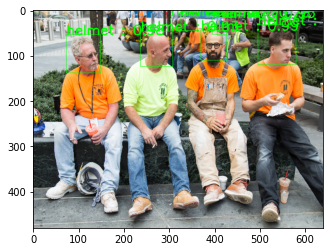

In [25]:
inference(onnx_path, "/content/helmet_test_3.jpg")